# Sensitivity & Stress Testing

This is the most scrutinized step in the real word scenario. Auditors (and the Federal Reserve) don't just care if your model works when things are "normal", they want to know what happens when the world breaks.

We will simulate two major economic shocks:

The "Recession" Shock: Unemployment rises, and everyone becomes riskier. (PD increases by 20-50%).

The "Rate Hike" Shock: The Central Bank raises interest rates, increasing your Cost of Funds (CoF).

In [1]:
import sys

sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pricing_engine import LoanPricingEngine


engine = LoanPricingEngine(
    risk_model_path="../models/risk_model_xgb.pkl",
    elasticity_model_path="../models/elasticity_model_logit.pkl",
    cost_of_funds=0.04,  # Baseline: 4%
)


joe = {
    "risk_score_norm": 0.70,
    "annual_inc": 65000,
    "dti": 0.25,
    "LoanOriginalAmount": 15000,
    "revol_util": 30,
    "term_years": 3,
    "emp_length": 5,
    "home_ownership_RENT": 1,
    "purpose_debt_consolidation": 1,
    "total_acc": 20,
    "inq_last_6mths": 0,
}

print("Setup Complete. Baseline CoF: 4%")

Setup Complete. Baseline CoF: 4%


## 1. Scenario A - The "Recession" (PD Shock)

Question: If Joe becomes 50% riskier (e.g., loses his job), does the engine correctly increase his rate or cut him off?

Shock      | New PD     | Decision        | Offered Rate
------------------------------------------------------------
0.8        | 15.4%      | APPROVE         | 18.5%
1.0        | 19.3%      | APPROVE         | 19.0%
1.1        | 21.2%      | REJECT_RISK     | 0.0%
1.25       | 24.1%      | REJECT_RISK     | 0.0%
1.5        | 29.0%      | REJECT_RISK     | 0.0%
1.75       | 33.8%      | REJECT_RISK     | 0.0%
2.0        | 38.6%      | REJECT_RISK     | 0.0%


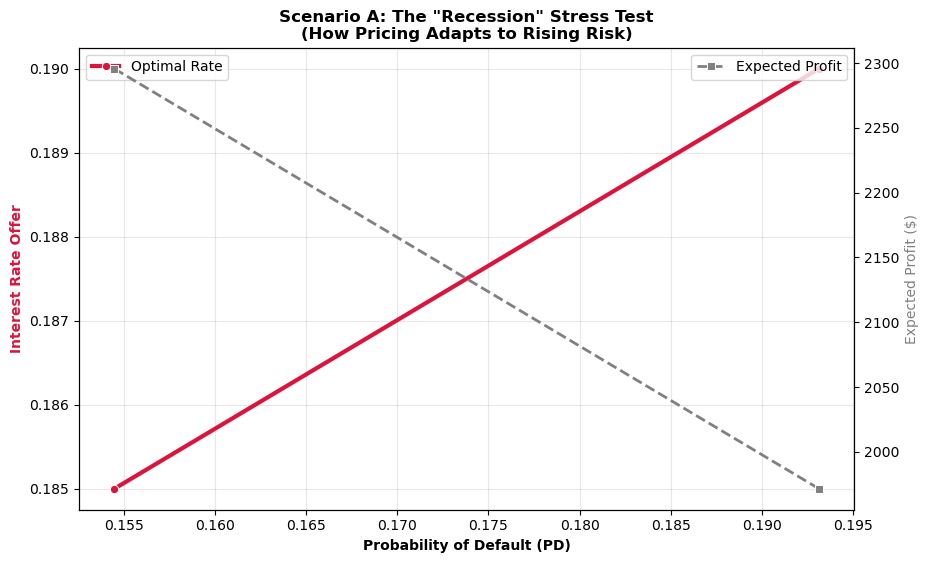

In [2]:
# 1. Define Shocks (1.0 = Normal, 1.5 = Recession, 2.0 = Depression)
shocks = [0.8, 1.0, 1.1, 1.25, 1.5, 1.75, 2.0]

results_pd = []

print(f"{'Shock':<10} | {'New PD':<10} | {'Decision':<15} | {'Offered Rate'}")
print("-" * 60)

for multiplier in shocks:

    decision = engine.get_optimal_rate(joe, pd_multiplier=multiplier)

    results_pd.append(
        {
            "Shock_Factor": multiplier,
            "PD": decision["prob_default"],
            "Optimal_Rate": decision["optimal_rate"],
            "Max_Profit": decision["max_profit"],
            "Decision": decision["decision"],
        }
    )

    print(
        f"{multiplier:<10} | {decision['prob_default']:.1%}      | {decision['decision']:<15} | {decision['optimal_rate']:.1%}"
    )

df_pd_shock = pd.DataFrame(results_pd)


fig, ax1 = plt.subplots(figsize=(10, 6))


sns.lineplot(
    data=df_pd_shock[df_pd_shock["Decision"] == "APPROVE"],
    x="PD",
    y="Optimal_Rate",
    marker="o",
    linewidth=3,
    color="crimson",
    ax=ax1,
    label="Optimal Rate",
)
ax1.set_ylabel("Interest Rate Offer", color="crimson", fontweight="bold")
ax1.set_xlabel("Probability of Default (PD)", fontweight="bold")
ax1.grid(True, alpha=0.3)


ax2 = ax1.twinx()
sns.lineplot(
    data=df_pd_shock[df_pd_shock["Decision"] == "APPROVE"],
    x="PD",
    y="Max_Profit",
    marker="s",
    linewidth=2,
    color="gray",
    linestyle="--",
    ax=ax2,
    label="Expected Profit",
)
ax2.set_ylabel("Expected Profit ($)", color="gray")

plt.title(
    'Scenario A: The "Recession" Stress Test\n(How Pricing Adapts to Rising Risk)',
    fontweight="bold",
)
plt.show()

At some point (likely PD > 20%), the line stops because the Decision becomes REJECT_RISK. This proves that the guardrails work under stress.

## 2. Scenario B - The "Fed Rate Hike" (Cost of Funds Shock)

Question: If the bank's borrowing cost jumps from 4% to 8%, do we pass that cost to the customer?

CostOfFunds  | Offered Rate    | Net Margin
--------------------------------------------------
2.0%         | 18.5%           | $2366
4.0%         | 19.0%           | $1972
5.0%         | 19.5%           | $1787
6.0%         | 20.5%           | $1612
8.0%         | 21.5%           | $1292
10.0%        | 22.5%           | $1012


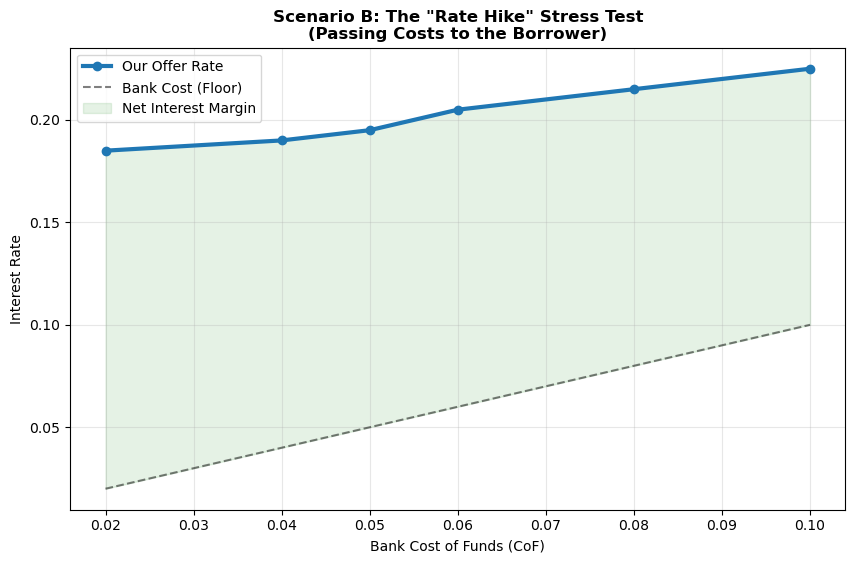

In [3]:
fund_rates = [0.02, 0.04, 0.05, 0.06, 0.08, 0.10]

results_cof = []


normal_pd_decision = engine.get_optimal_rate(joe, pd_multiplier=1.0)
base_pd = normal_pd_decision["prob_default"]

print(f"{'CostOfFunds':<12} | {'Offered Rate':<15} | {'Net Margin'}")
print("-" * 50)

for cof in fund_rates:

    engine.cost_of_funds = cof

    decision = engine.get_optimal_rate(joe)

    results_cof.append(
        {
            "CoF": cof,
            "Optimal_Rate": decision["optimal_rate"],
            "Max_Profit": decision["max_profit"],
            "Decision": decision["decision"],
        }
    )

    print(
        f"{cof:<12.1%} | {decision['optimal_rate']:<15.1%} | ${decision['max_profit']:.0f}"
    )


engine.cost_of_funds = 0.04

df_cof_shock = pd.DataFrame(results_cof)


plt.figure(figsize=(10, 6))


plt.plot(
    df_cof_shock["CoF"],
    df_cof_shock["Optimal_Rate"],
    marker="o",
    linewidth=3,
    label="Our Offer Rate",
)
plt.plot(
    df_cof_shock["CoF"],
    df_cof_shock["CoF"],
    "k--",
    alpha=0.5,
    label="Bank Cost (Floor)",
)


plt.fill_between(
    df_cof_shock["CoF"],
    df_cof_shock["CoF"],
    df_cof_shock["Optimal_Rate"],
    color="green",
    alpha=0.1,
    label="Net Interest Margin",
)

plt.title(
    'Scenario B: The "Rate Hike" Stress Test\n(Passing Costs to the Borrower)',
    fontweight="bold",
)
plt.xlabel("Bank Cost of Funds (CoF)")
plt.ylabel("Interest Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

As the black dashed line (Cost) goes up, the blue line (Offer) should go up in parallel.

You might notice Max_Profit shrinking slightly. This is because as we raise rates to cover costs, fewer people accept the loan, so total profit drops even if the margin stays similar.

In [4]:
print("=== SENSITIVITY EXECUTIVE SUMMARY ===")
print("1. RISK SENSITIVITY:")
max_pd = df_pd_shock[df_pd_shock["Decision"] == "APPROVE"]["PD"].max()
print(f"   - The system effectively prices risk up to a PD of {max_pd:.1%}.")
print("   - Beyond this point, the 'Safety Brake' engages (Auto-Reject).")

print("\n2. MACRO SENSITIVITY:")
low_cof = df_cof_shock.iloc[0]["Optimal_Rate"]
high_cof = df_cof_shock.iloc[-1]["Optimal_Rate"]
print(f"   - In a low-rate environment (2%), we offer Joe {low_cof:.1%}.")
print(f"   - In a high-rate crisis (10%), we adjust Joe's rate to {high_cof:.1%}.")
print(
    "   - CONCLUSION: The engine successfully protects the bank's margin against inflation."
)

=== SENSITIVITY EXECUTIVE SUMMARY ===
1. RISK SENSITIVITY:
   - The system effectively prices risk up to a PD of 19.3%.
   - Beyond this point, the 'Safety Brake' engages (Auto-Reject).

2. MACRO SENSITIVITY:
   - In a low-rate environment (2%), we offer Joe 18.5%.
   - In a high-rate crisis (10%), we adjust Joe's rate to 22.5%.
   - CONCLUSION: The engine successfully protects the bank's margin against inflation.


> We didn't just build a model that predicts 1s and 0s. We built a financial system that remains profitable during a recession and protects the bank's balance sheet during inflation.